<a href="https://colab.research.google.com/github/qbx11/emotion-recognition/blob/main/emotion_recogniction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class distribution:
emotion
Angry       4953
Fear        5121
Happy       8989
Sad         6077
Surprise    4002
Neutral     6198
Name: count, dtype: int64
Train: 24738, Val: 5301, Test: 5301
Parameters: 2145542


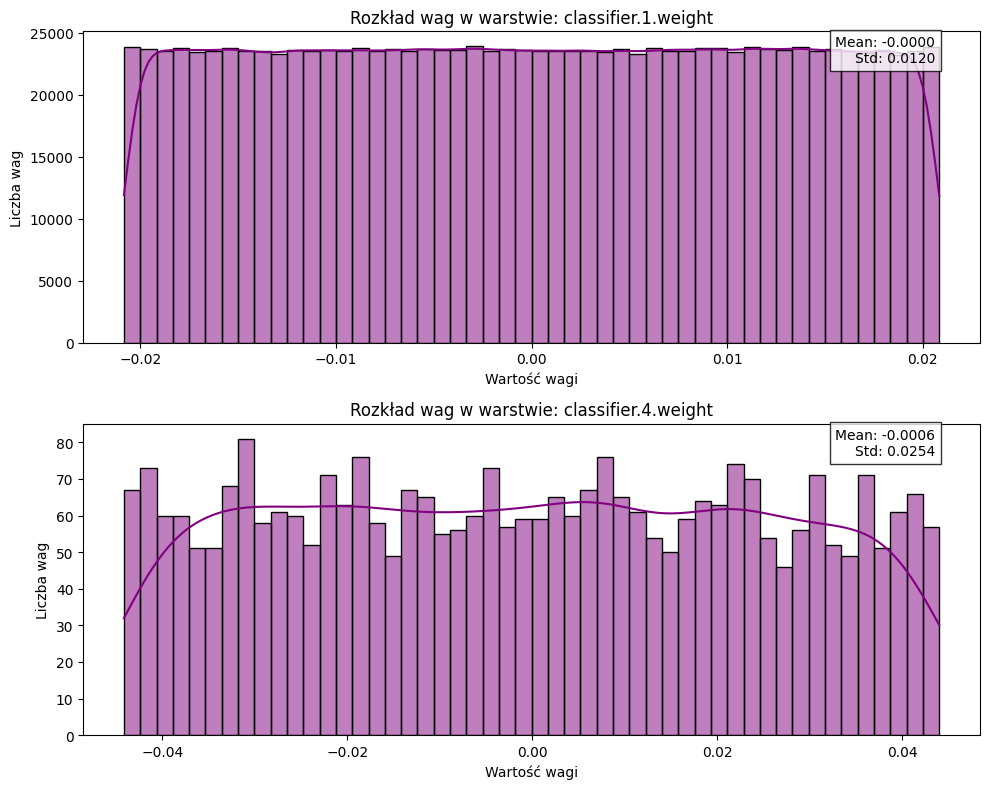

Epoch 01 | Train Loss: 1.2139 | Val Loss: 1.0874 | Train Acc: 25.31% | Val Acc: 31.60%


Epoch 02 | Train Loss: 1.0478 | Val Loss: 0.9289 | Train Acc: 33.75% | Val Acc: 43.48%


Epoch 03 | Train Loss: 0.9801 | Val Loss: 0.8925 | Train Acc: 38.17% | Val Acc: 43.27%


Epoch 04 | Train Loss: 0.9286 | Val Loss: 0.8110 | Train Acc: 40.83% | Val Acc: 48.71%


Epoch 05 | Train Loss: 0.8945 | Val Loss: 0.7462 | Train Acc: 43.05% | Val Acc: 50.44%


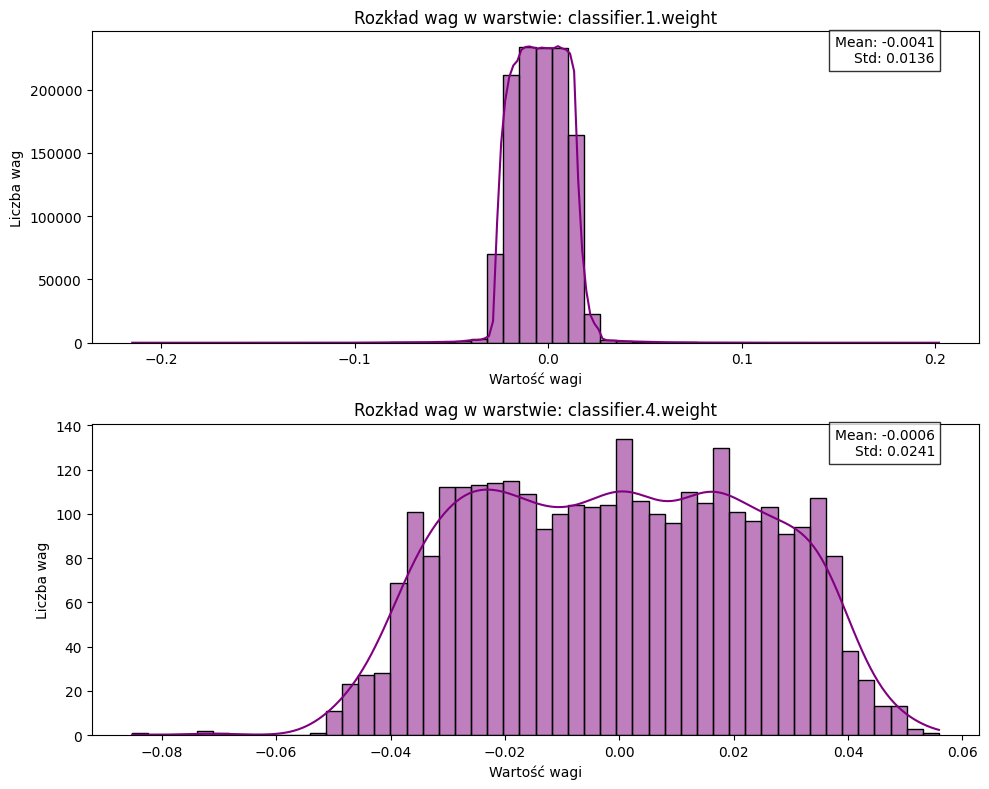

Epoch 06 | Train Loss: 0.8715 | Val Loss: 0.7344 | Train Acc: 43.70% | Val Acc: 52.39%


Epoch 07 | Train Loss: 0.8480 | Val Loss: 0.7028 | Train Acc: 44.80% | Val Acc: 53.05%


Epoch 08 | Train Loss: 0.8251 | Val Loss: 0.7149 | Train Acc: 45.85% | Val Acc: 53.41%


Epoch 09 | Train Loss: 0.8121 | Val Loss: 0.7076 | Train Acc: 46.96% | Val Acc: 53.67%


Epoch 10 | Train Loss: 0.8033 | Val Loss: 0.6746 | Train Acc: 47.37% | Val Acc: 55.59%


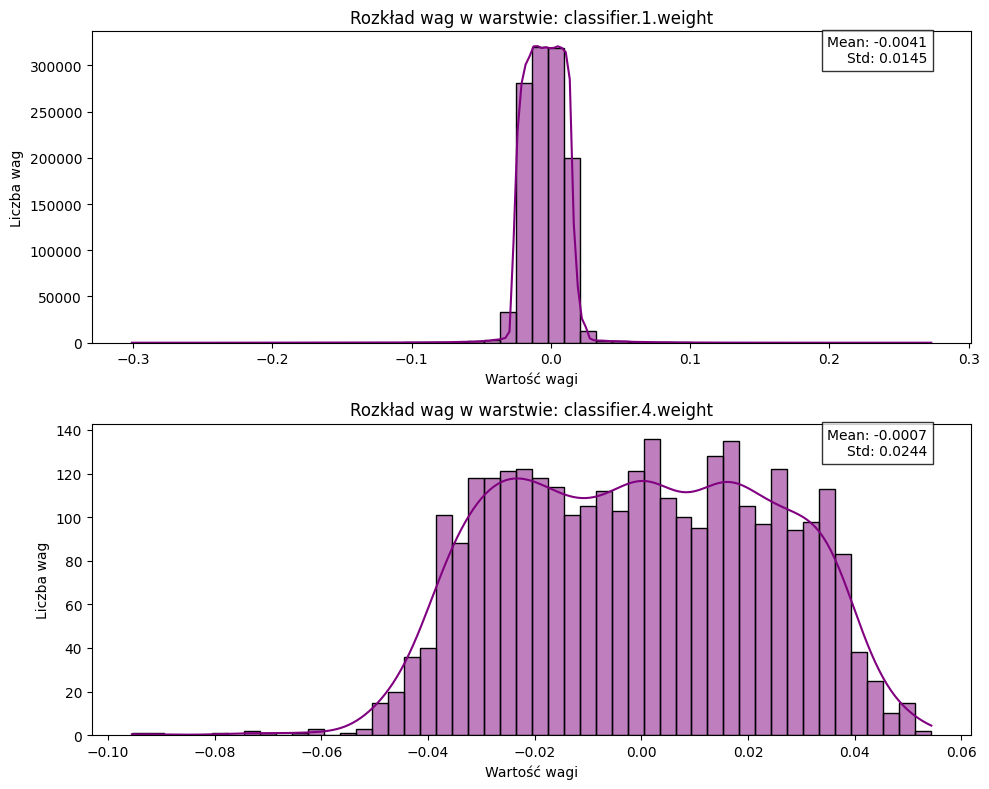

Epoch 11 | Train Loss: 0.7903 | Val Loss: 0.6722 | Train Acc: 47.70% | Val Acc: 55.05%


Epoch 12 | Train Loss: 0.7783 | Val Loss: 0.6583 | Train Acc: 48.38% | Val Acc: 55.48%


Epoch 13 | Train Loss: 0.7680 | Val Loss: 0.6450 | Train Acc: 48.97% | Val Acc: 55.73%


Epoch 14 | Train Loss: 0.7649 | Val Loss: 0.6631 | Train Acc: 49.31% | Val Acc: 54.22%


Epoch 15 | Train Loss: 0.7563 | Val Loss: 0.6353 | Train Acc: 49.80% | Val Acc: 56.44%


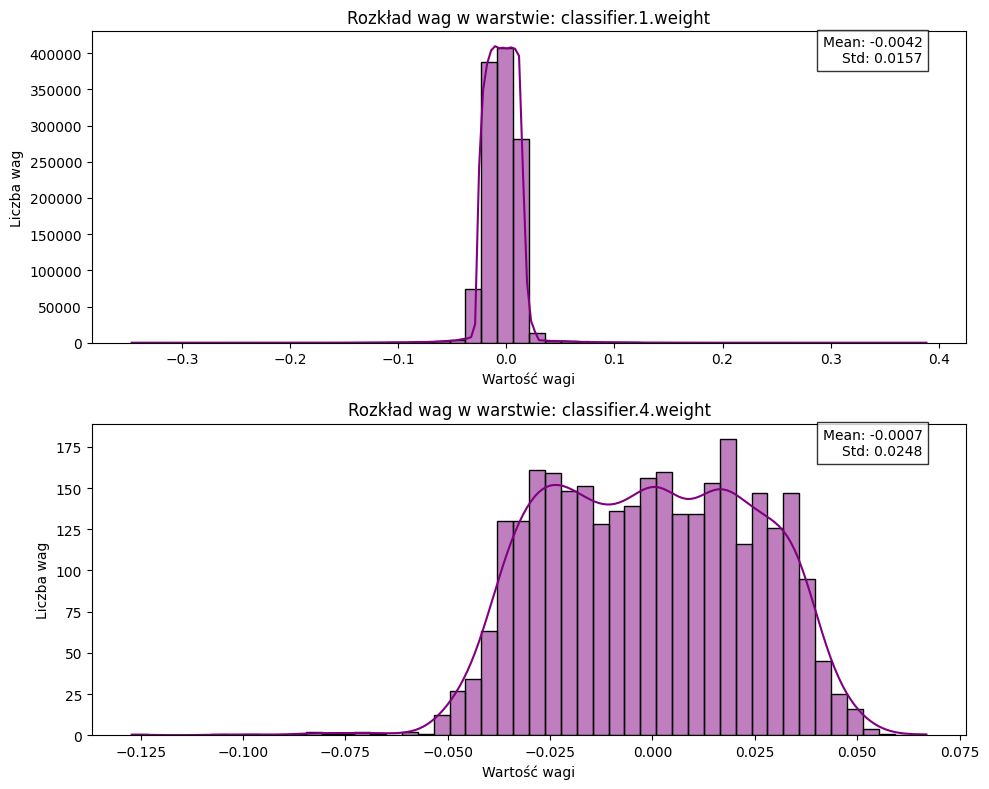

Epoch 16 | Train Loss: 0.7486 | Val Loss: 0.6556 | Train Acc: 49.99% | Val Acc: 55.42%


Epoch 17 | Train Loss: 0.7352 | Val Loss: 0.6130 | Train Acc: 50.22% | Val Acc: 58.46%


Epoch 18 | Train Loss: 0.7267 | Val Loss: 0.6114 | Train Acc: 51.20% | Val Acc: 58.03%


Epoch 19 | Train Loss: 0.7213 | Val Loss: 0.6162 | Train Acc: 51.35% | Val Acc: 58.29%


Epoch 20 | Train Loss: 0.7136 | Val Loss: 0.6093 | Train Acc: 51.56% | Val Acc: 58.48%


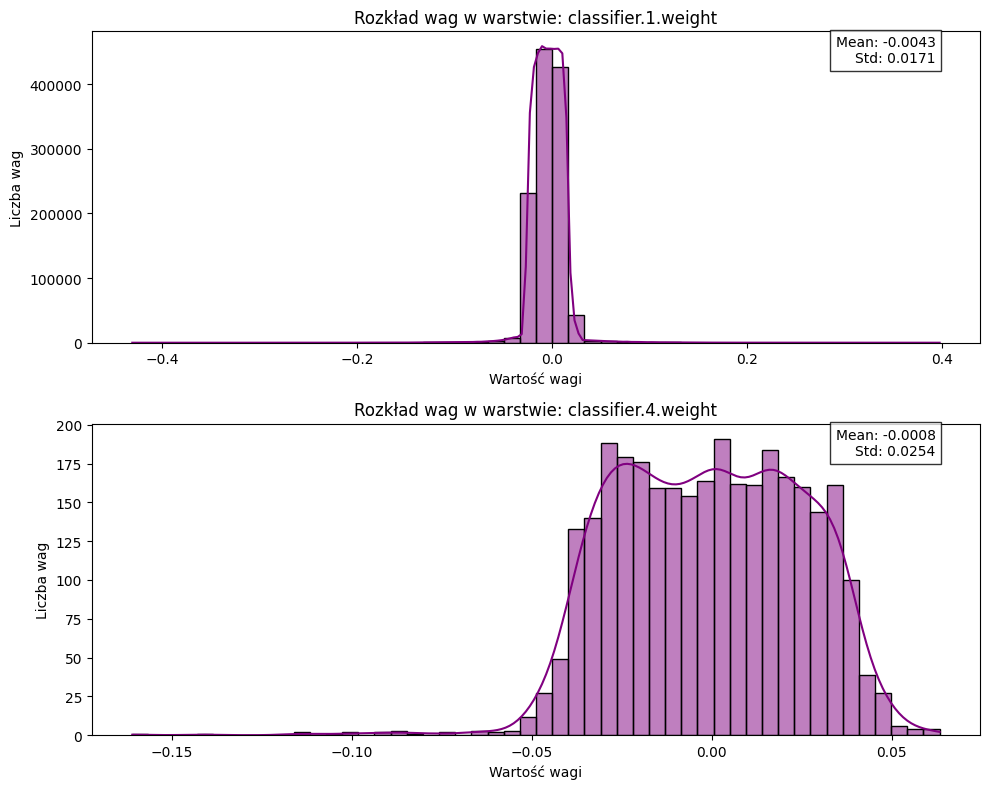

Epoch 21 | Train Loss: 0.6995 | Val Loss: 0.6417 | Train Acc: 52.61% | Val Acc: 58.46%


Epoch 22 | Train Loss: 0.6975 | Val Loss: 0.6073 | Train Acc: 52.69% | Val Acc: 58.71%


Epoch 23 | Train Loss: 0.6857 | Val Loss: 0.5872 | Train Acc: 53.40% | Val Acc: 60.27%


Epoch 24 | Train Loss: 0.6777 | Val Loss: 0.5922 | Train Acc: 53.88% | Val Acc: 59.82%


Epoch 25 | Train Loss: 0.6712 | Val Loss: 0.5925 | Train Acc: 53.87% | Val Acc: 59.97%


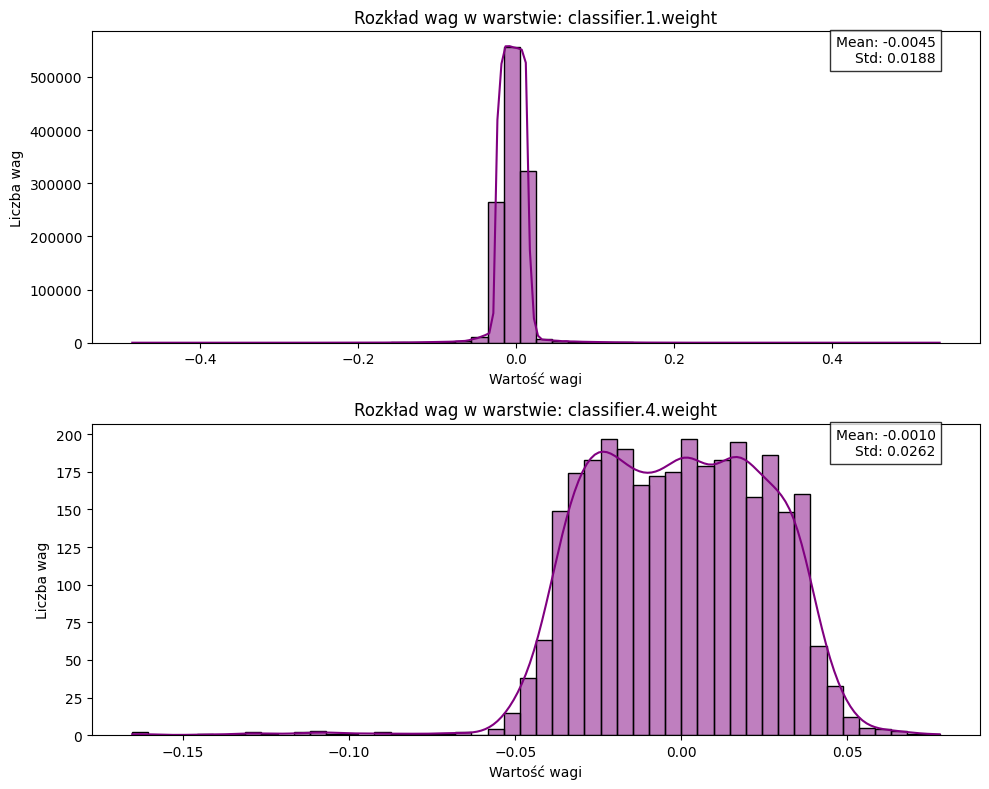


Test Accuracy: 0.5932842859837767

Classification Report:
              precision    recall  f1-score   support

       Angry       0.53      0.40      0.46       743
        Fear       0.46      0.19      0.27       768
       Happy       0.79      0.88      0.83      1348
         Sad       0.40      0.57      0.47       911
    Surprise       0.67      0.79      0.73       601
     Neutral       0.57      0.56      0.57       930

    accuracy                           0.59      5301
   macro avg       0.57      0.57      0.55      5301
weighted avg       0.59      0.59      0.58      5301



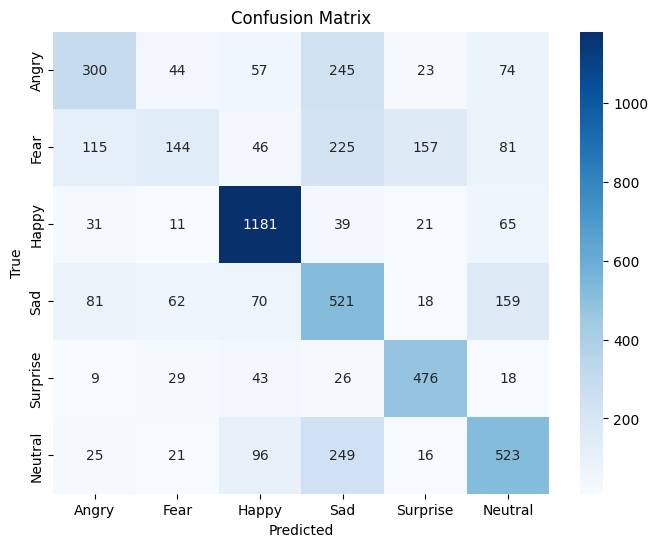

In [3]:
# FER2013 Emotion Recognition

import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#Setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_path = "fer2013.csv"

#Load & filter dataset (exluding 'disgust')
df = pd.read_csv(csv_path)

def is_valid_pixels(p):
    if not isinstance(p, str):
        return False
    return len(p.split()) == 48 * 48
#deleting corrupted data
df = df[df["pixels"].apply(is_valid_pixels)].copy()


#deleting 'disgust'
df = df[df["emotion"] != 1].copy()

#labels remap
label_map = {
    0: 0,  # Angry
    2: 1,  # Fear
    3: 2,  # Happy
    4: 3,  # Sad
    5: 4,  # Surprise
    6: 5   # Neutral
}

emotion_names = {
    0: "Angry",
    1: "Fear",
    2: "Happy",
    3: "Sad",
    4: "Surprise",
    5: "Neutral"
}

df["emotion"] = df["emotion"].map(label_map)

print("Class distribution:")
print(df["emotion"].value_counts().sort_index().rename(index=emotion_names))

NUM_CLASSES = 6

# Dataset
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pixels = np.fromstring(row["pixels"], dtype=np.uint8, sep=" ").reshape(48, 48)
        img = Image.fromarray(pixels).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["emotion"])
        return img, torch.tensor(label, dtype=torch.long)

# Augmentation

def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05)
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

#DataLoaders
df_train, df_temp = train_test_split(
    df, test_size=0.30, stratify=df["emotion"], random_state=SEED
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["emotion"], random_state=SEED
)

train_ds = FER2013Dataset(df_train, get_transforms(train=True))
val_ds   = FER2013Dataset(df_val,   get_transforms(train=False))
test_ds  = FER2013Dataset(df_test,  get_transforms(train=False))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

#CNN ARCHITECTURE

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(3, 64),     # 48 -> 24
            block(64, 128),   # 24 -> 12
            block(128, 256),  # 12 -> 6
            block(256, 256)   # 6 -> 3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = EmotionCNN(NUM_CLASSES).to(device)
print("Parameters:", sum(p.numel() for p in model.parameters()))

# FOCAL LOSS

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, 100 * correct / total

def eval_epoch(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss / total, 100 * correct / total

def visualize_weight_distribution(model):
    layers_with_weights = [
        (name, param) for name, param in model.named_parameters()
        if 'weight' in name and ('conv' in name or 'fc' in name or 'classifier' in name)
    ]

    num_layers = len(layers_with_weights)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, 4 * num_layers))
    if num_layers == 1: axes = [axes]

    for ax, (name, param) in zip(axes, layers_with_weights):
        #Flatten
        weights = param.data.cpu().numpy().flatten()

        #histogram
        sns.histplot(weights, kde=True, ax=ax, bins=50, color='purple')

        ax.set_title(f'Rozkład wag w warstwie: {name}')
        ax.set_xlabel('Wartość wagi')
        ax.set_ylabel('Liczba wag')

        mean = weights.mean()
        std = weights.std()
        ax.text(0.95, 0.9, f'Mean: {mean:.4f}\nStd: {std:.4f}',
                transform=ax.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

visualize_weight_distribution(model)

# Train

EPOCHS = 25
best_val = 0

history = {
    "train_acc": [], "val_acc": [],
    "train_loss": [], "val_loss": []
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    va_loss, va_acc = eval_epoch(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | Train Acc: {tr_acc:.2f}% | Val Acc: {va_acc:.2f}%")

    if epoch%5 == 0:
        visualize_weight_distribution(model)

    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), "best_model.pth")

# Test evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())

print("\nTest Accuracy:", np.mean(np.array(all_preds) == np.array(all_labels)))

print("\nClassification Report:")
print(classification_report(
    all_labels, all_preds,
    target_names=[emotion_names[i] for i in range(NUM_CLASSES)]
))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=emotion_names.values(),
    yticklabels=emotion_names.values()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


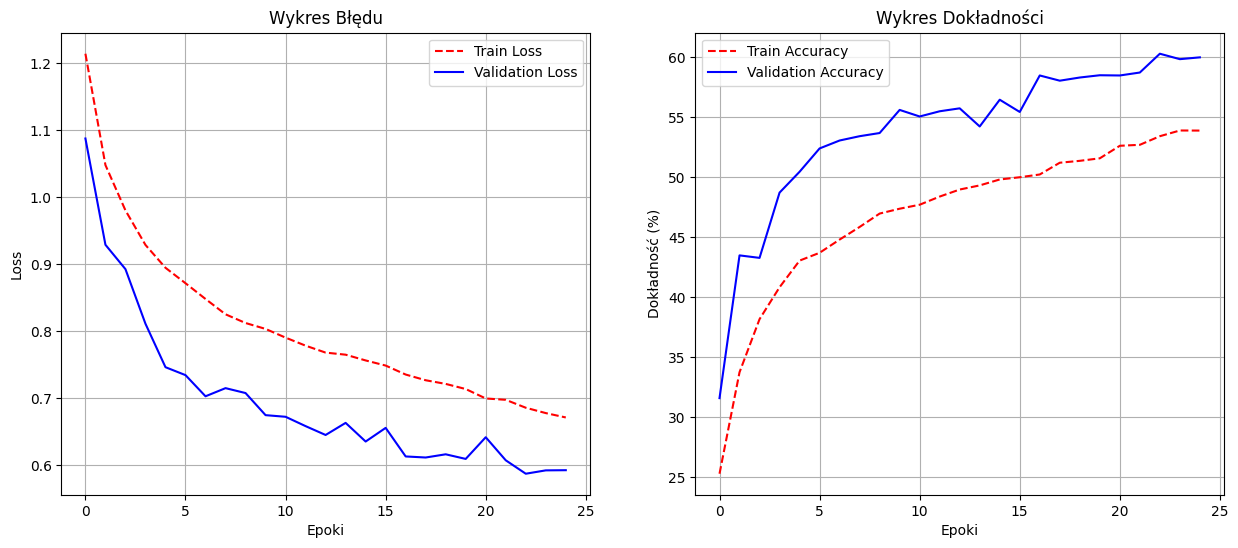

In [4]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Wykres 1: Błąd (Loss)
    ax1.plot(history['train_loss'], label='Train Loss', color='red', linestyle='--')
    ax1.plot(history['val_loss'], label='Validation Loss', color='blue')
    ax1.set_title('Wykres Błędu')
    ax1.set_xlabel('Epoki')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Wykres 2: Dokładność (Accuracy)
    ax2.plot(history['train_acc'], label='Train Accuracy', color='red', linestyle='--')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='blue')
    ax2.set_title('Wykres Dokładności')
    ax2.set_xlabel('Epoki')
    ax2.set_ylabel('Dokładność (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Wywołanie funkcji
plot_training_history(history)

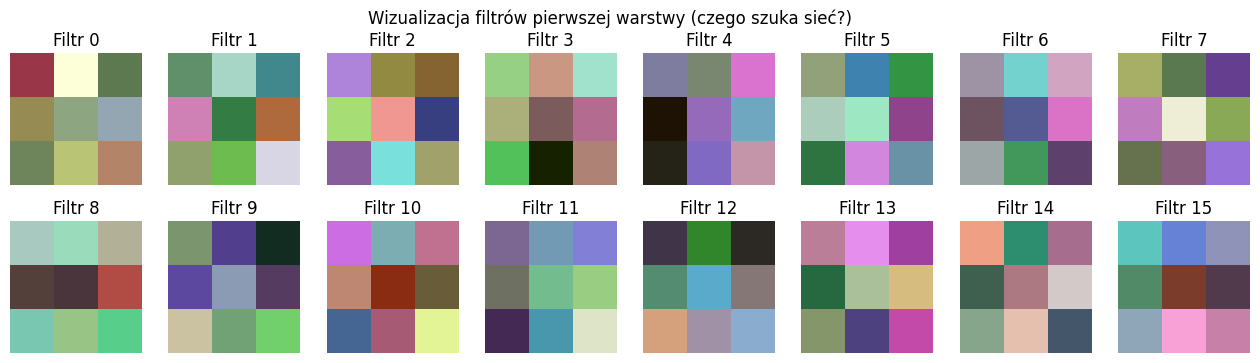

In [5]:
def visualize_first_layer_filters(model):
    # Pobieramy wagi z pierwszej warstwy konwolucyjnej
    # W Twoim modelu jest to model.features[0][0] (Conv2d)
    first_conv_layer = model.features[0][0]
    weights = first_conv_layer.weight.data.cpu()

    # weights ma kształt: [64, 3, 3, 3] (out_channels, in_channels, H, W)
    # Znormalizujmy je do zakresu 0-1 żeby wyświetlić jako obrazek
    min_w = weights.min()
    max_w = weights.max()
    weights = (weights - min_w) / (max_w - min_w)

    num_filters = 16  # Pokażmy pierwsze 16 z 64 filtrów
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # Bierzemy i-ty filtr. Ma wymiary (3, 3, 3) -> idealne dla RGB
            # PyTorch trzyma (C, H, W), matplotlib chce (H, W, C) -> permutacja
            img = weights[i].permute(1, 2, 0).numpy()

            # Upscaling (powiększenie), bo 3x3 piksele to za mało żeby coś zobaczyć
            img_big = np.kron(img, np.ones((10, 10, 1)))

            ax.imshow(img_big)
            ax.axis('off')
            ax.set_title(f'Filtr {i}')

    plt.suptitle("Wizualizacja filtrów pierwszej warstwy (czego szuka sieć?)")
    plt.show()

visualize_first_layer_filters(model)